In [4]:
from datasets import Dataset
from config import postprocessing
from utils.evaluator import Evaluator
from utils.output_cleaner import OutputCleaner

similar_is_equal_list = postprocessing.similar_is_equal_list
similar_is_equal_threshold_list = postprocessing.similar_is_equal_threshold_list

/home/pferrazzi/miniconda3/envs/lm_finetune_env/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
import glob
import pandas as pd
#adapters_list = generate_ft_adapters_list("enlayer1_3epochs_4bits__ft_params")
evaluators = {}
csv_files = glob.glob('data/test_data_processed/*.csv') #'data/mistral/test_data_processed/*.csv'
#csv_files = ['data/test_data_processed/maxNewTokensFactor4_nShotsInference2_Mistral-7B-Instruct-v0.2_adapters_en.layer1_4_torch.bfloat16_16_32_0.05_2_0.0002.csv']
evaluation_results = pd.DataFrame(columns=['file', 'similar_is_equal', 'similar_is_equal_threshold', 'f1_score', 'precision', 'recall'])

print(evaluation_results)
for file in csv_files:
    if file.strip().endswith('0.002.csv'):
        continue
    print("FILE: " , file)
    eval_data = Dataset.from_csv(file) 
    output_cleaner = OutputCleaner()
    cleaned_data = output_cleaner.apply_cleaning(eval_data, wrong_keys_to_entity=False)
    for similar_is_equal in similar_is_equal_list:
        if similar_is_equal:
            for similar_is_equal_threshold in similar_is_equal_threshold_list:
                # evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                # evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal_threshold, similar_is_equal_threshold=similar_is_equal_threshold)
                # evaluators[f"{file}_SimilarIsEqual{similar_is_equal}_Threshold{similar_is_equal_threshold}"] = evaluator
                # evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                                
                try:
                    evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                    evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal_threshold, similar_is_equal_threshold=similar_is_equal_threshold)
                    evaluators[f"{file}_SimilarIsEqual{similar_is_equal}_Threshold{similar_is_equal_threshold}"] = evaluator
                    evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                    # print('DONE')
                except:
                    break
        elif not similar_is_equal:
            # evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
            # evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal, similar_is_equal_threshold=100)
            # evaluators[f"{file}_SimilarIsEqual{similar_is_equal}"] = evaluator
            # evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
            
            try:
                evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal, similar_is_equal_threshold=100)
                evaluators[f"{file}_SimilarIsEqual{similar_is_equal}"] = evaluator
                evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                # print('DONE')
            except:
                #print('SKIPPING THIS')
                break


In [15]:
## evaluation_results.to_csv('data/mistral/evaluation_results/results.csv', index=False)

In [23]:
evaluation_results[evaluation_results['similar_is_equal_threshold'] >= 100].sort_values(by='f1_score', ascending=False)['file'].to_list()[0:5]

['data/test_data_processed/maxNewTokensFactor8_nShotsInference2_Mistral-7B-Instruct-v0.2_adapters_en.layer1_4_torch.bfloat16_32_32_0.05_8_0.0002.csv',
 'data/test_data_processed/maxNewTokensFactor4_nShotsInference2_Mistral-7B-Instruct-v0.2_adapters_en.layer1_4_torch.bfloat16_16_32_0.05_4_0.0002.csv',
 'data/test_data_processed/maxNewTokensFactor8_nShotsInference2_Mistral-7B-Instruct-v0.2_adapters_en.layer1_4_torch.bfloat16_32_32_0.05_4_0.0002.csv',
 'data/test_data_processed/maxNewTokensFactor4_nShotsInference2_Mistral-7B-Instruct-v0.2_adapters_en.layer1_4_torch.bfloat16_32_32_0.05_4_0.0002.csv',
 'data/test_data_processed/maxNewTokensFactor4_nShotsInference2_Mistral-7B-Instruct-v0.2_adapters_en.layer1_4_torch.bfloat16_32_32_0.05_8_0.0002.csv']

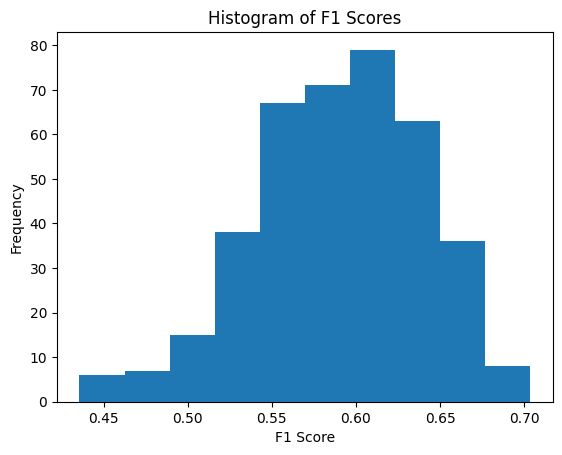

In [13]:
f1 = []
for _,eval in evaluators.items():
    f1.append(eval.evaluation_table['f1'])

import matplotlib.pyplot as plt

plt.hist(f1)
plt.xlabel('F1 Score')
plt.ylabel('Frequency')
plt.title('Histogram of F1 Scores')
plt.show()


### One Run

In [ ]:
file = 'data/mistral/8bit/maxNewTokensFactor8_nShotsInference4_Mistral-7B-Instruct-v0.2_adapters_en.layer1_8_torch.bfloat16_32_32_0.05_2_0.0002.csv'
eval_data = Dataset.from_csv(file) 
#display(eval_data.to_pandas().head(3))
output_cleaner = OutputCleaner()
similar_is_equal = False
similar_is_equal_threshold = 80
cleaned_data = output_cleaner.apply_cleaning(eval_data, wrong_keys_to_entity=False)#.select(range(138,139))

evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal, similar_is_equal_threshold=similar_is_equal_threshold)


### BASE MODEL MISTRAL

In [26]:
import glob
import pandas as pd
#adapters_list = generate_ft_adapters_list("enlayer1_3epochs_4bits__ft_params")
evaluators = {}
csv_files = glob.glob('data/mistral/test_data_processed/*.csv') #'data/mistral/test_data_processed/*.csv'
#csv_files = ['data/test_data_processed/maxNewTokensFactor4_nShotsInference2_Mistral-7B-Instruct-v0.2_adapters_en.layer1_4_torch.bfloat16_16_32_0.05_2_0.0002.csv']
evaluation_results = pd.DataFrame(columns=['file', 'similar_is_equal', 'similar_is_equal_threshold', 'f1_score', 'precision', 'recall'])

print(evaluation_results)
for file in csv_files:
    if not file.strip().endswith('BaseModel.csv'):
        continue
    print("FILE: " , file)
    eval_data = Dataset.from_csv(file) 
    output_cleaner = OutputCleaner()
    cleaned_data = output_cleaner.apply_cleaning(eval_data, wrong_keys_to_entity=False)
    for similar_is_equal in similar_is_equal_list:
        if similar_is_equal:
            for similar_is_equal_threshold in similar_is_equal_threshold_list:
                # evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                # evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal_threshold, similar_is_equal_threshold=similar_is_equal_threshold)
                # evaluators[f"{file}_SimilarIsEqual{similar_is_equal}_Threshold{similar_is_equal_threshold}"] = evaluator
                # evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                                
                try:
                    evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                    evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal_threshold, similar_is_equal_threshold=similar_is_equal_threshold)
                    evaluators[f"{file}_SimilarIsEqual{similar_is_equal}_Threshold{similar_is_equal_threshold}"] = evaluator
                    evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                    # print('DONE')
                except:
                    break
        elif not similar_is_equal:
            # evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
            # evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal, similar_is_equal_threshold=100)
            # evaluators[f"{file}_SimilarIsEqual{similar_is_equal}"] = evaluator
            # evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
            
            try:
                evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal, similar_is_equal_threshold=100)
                evaluators[f"{file}_SimilarIsEqual{similar_is_equal}"] = evaluator
                evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                # print('DONE')
            except:
                #print('SKIPPING THIS')
                break


Empty DataFrame
Columns: [file, similar_is_equal, similar_is_equal_threshold, f1_score, precision, recall]
Index: []
FILE:  data/mistral/test_data_processed/maxNewTokensFactor8_nShotsInference0_BaseModel.csv


Map:   0%|          | 0/681 [00:00<?, ? examples/s]

Map: 100%|██████████| 681/681 [00:00<00:00, 6744.24 examples/s]

CLEANED:  [{ "Value": "a 46-year-old man"}, { "Value": "46-year-old"}, { "Value": "hypertension"}, { "Value": "dyslipidemia"}]
CLEANED:  []
CLEANED:  []
CLEANED:  [{"Type": "PERSON"}, {"Type": "MEDICAL_PROCEDURE"}, {"Type": "DISEASE"}]
CLEANED:  []
CLEANED:  []
CLEANED:  []
CLEANED:  [{"Type": "PERSON"}, {"Type": "QUANTITY"}]
CLEANED:  [{"text": "thyroid dysfunction"}]
CLEANED:  []
CLEANED:  []
CLEANED:  []
CLEANED:  []
CLEANED:  []
CLEANED:  []
CLEANED:  []
CLEANED:  []
CLEANED:  []
CLEANED:  []
CLEANED:  []
CLEANED:  []
CLEANED:  [{"Entity": "patient"}, {"Entity": "surgery"}, {"Entity": "MNG"}, {"Entity": "mediastinum"}]
CLEANED:  []
CLEANED:  []
CLEANED:  []
CLEANED:  []
CLEANED:  []
CLEANED:  []
CLEANED:  []
CLEANED:  []
CLEANED:  []
CLEANED:  []
CLEANED:  []
CLEANED:  []
CLEANED:  [{"type": "PERSON"}, {"type": "ORGANIZATION"}]
CLEANED:  [{"name": "21-year-old male"}]
CLEANED:  []
CLEANED:  []
CLEANED:  [{" type": "Disease"}, {" type": "Person"}, {" type": "SUBSTANCE"}, {" type": "

FILE:  data/mistral/test_data_processed/maxNewTokensFactor8_nShotsInference4_BaseModel.csv
FILE:  data/mistral/test_data_processed/maxNewTokensFactor8_nShotsInference2_BaseModel.csv


Map:   0%|          | 0/681 [00:00<?, ? examples/s]

CLEANED:  [{"entity": "man"}, {"entity": "46-year-old"}, {"entity": " hypertension"}, {"entity": "dyslipidemia"}, {"entity": "diagnosed"}, {"entity": "4-months"}, {"entity": "new-onset diabetes mellitus"}, {"entity": "unveiled"}, {"entity": "1-month"}, {"entity": "referred"}, {"entity": "man"}, {"entity": "46-year-old"}]
CLEANED:  []
CLEANED:  [{"entity": "imaging"}, {"entity": "cytological findings"}, {"entity": "primary"}, {"entity": "right parotid malignancy"}, {"entity": "liver metastases"}]
CLEANED:  [{"entity": "patient"}, {"entity": "underwent"}, {"entity": "right parotidectomy"}, {"entity": "ACC"}, {"entity": "ACC": "Acinic Cell Carcinoma"}]
CLEANED:  [{"entity": "hypercortisolism"}, {"entity": "managed"}, {"entity": "metyrapone"}, {"entity": "ketoconazole"}, {"entity": "lanreotide"}]
CLEANED:  [{"entity": "woman"}, {"entity": "50-years-old"}, {"entity": "hospitalized"}, {"entity": "appeared"}, {"entity": "30-years-ago"}, {"entity": "large"}, {"entity": "cervical mass"}]
CLEANE

Map: 100%|██████████| 681/681 [00:00<00:00, 5969.90 examples/s]


FILE:  data/mistral/test_data_processed/maxNewTokensFactor8_nShotsInference3_BaseModel.csv


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1027.26it/s]
Generating train split: 681 examples [00:00, 14899.72 examples/s]
Map: 100%|██████████| 681/681 [00:00<00:00, 6066.05 examples/s]


CLEANED:  [{"entity": "referred"}, {"entity": "emergency department"}, {"entity": "46-year-old man"}, {"entity": "hypertension"}, {"entity": "dyslipidemia"}, {"entity": "diagnosed"}, {"entity": "4-months"}, {"entity": "new-onset diabetes mellitus"}, {"entity": "unveiled"}, {"entity": "1-month earlier"}, {"entity": "hypokalemia"}]
CLEANED:  [{"entity": "hormonal study"}, {"entity": "dynamic biochemical tests"}, {"entity": "ECS"}, {"entity": "12-lead ECG"}]
CLEANED:  [{"entity": "imaging"}, {"entity": "findings"}, {"entity": "likely"}, {"entity": "primary"}, {"entity": "right parotid"}, {"entity": "malignancy"}, {"entity": "liver metastases"}]
CLEANED:  [{"entity": "patient"}, {"entity": "underwent"}, {"entity": "right parotidectomy"}, {"entity": "histopathologic examination"}, {"entity": "ACC"}]
CLEANED:  [{"entity": "managed"}, {"entity": "hypercortisolism"}, {"entity": "metyrapone"}, {"entity": "ketoconazole"}, {"entity": "lanreotide"}]
CLEANED:  [{"entity": "woman"}, {"entity": "50-y

Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1036.91it/s]
Generating train split: 681 examples [00:00, 18774.05 examples/s]
Map: 100%|██████████| 681/681 [00:00<00:00, 5956.84 examples/s]


CLEANED:  [{"entity": "A"}, {"entity": "46-year-old"}, {"entity": "man"}, {"entity": "history"}, {"entity": "hypertension"}, {"entity": "dyslipidemia"}, {"entity": "diagnosed"}, {"entity": "4-months before"}, {"entity": "new-onset diabetes mellitus"}, {"entity": "unveiled"}, {"entity": "1-month earlier"}, {"entity": "referred"}]
CLEANED:  [{"entity": "hormonal study"}, {"entity": "dynamic biochemical tests"}, {"entity": "ECS"}]
CLEANED:  [{"entity": "imaging"}, {"entity": "cytological findings"}, {"entity": "primary right parotid malignancy"}, {"entity": "liver metastases"}]
CLEANED:  [{"entity": "patient"}, {"entity": "right parotidectomy"}, {"entity": "ACC"}]
CLEANED:  [{"entity": "hypercortisolism"}, {"entity": "metyrapone"}, {"entity": "ketoconazole"}, {"entity": "lanreotide"}]
CLEANED:  [{"entity": "woman"}, {"entity": "50-years-old"}, {"entity": "hospitalized"}, {"entity": "large cervical mass"}, {"entity": "appeared"}, {"entity": "30 years ago"}, {"entity": "hypertensive"}]
CLEA

In [28]:
evaluation_results[evaluation_results['similar_is_equal_threshold'] >= 80].sort_values(by='f1_score', ascending=False)

,file,similar_is_equal,similar_is_equal_threshold,f1_score,precision,recall
13,data/mistral/test_data_processed/maxNewTokensF...,True,80,0.466546,0.445486,0.489696
23,data/mistral/test_data_processed/maxNewTokensF...,True,80,0.463026,0.446798,0.480477
33,data/mistral/test_data_processed/maxNewTokensF...,True,80,0.461848,0.456885,0.466920
22,data/mistral/test_data_processed/maxNewTokensF...,True,85,0.451200,0.434859,0.468818
12,data/mistral/test_data_processed/maxNewTokensF...,True,85,0.446995,0.426217,0.469902
32,data/mistral/test_data_processed/maxNewTokensF...,True,85,0.445845,0.440880,0.450922
21,data/mistral/test_data_processed/maxNewTokensF...,True,90,0.442473,0.426345,0.459870
43,data/mistral/test_data_processed/maxNewTokensF...,True,80,0.441708,0.445856,0.437636
20,data/mistral/test_data_processed/maxNewTokensF...,True,95,0.440010,0.423869,0.457430
28,data/mistral/test_data_processed/maxNewTokensF...,True,100,0.438910,0.422758,0.456345


## MISTRAL 8bit

In [ ]:
import glob
import pandas as pd
from datasets import Dataset
from config import postprocessing
from utils.evaluator import Evaluator
from utils.output_cleaner import OutputCleaner

similar_is_equal_list = postprocessing.similar_is_equal_list
similar_is_equal_threshold_list = postprocessing.similar_is_equal_threshold_list
#adapters_list = generate_ft_adapters_list("enlayer1_3epochs_4bits__ft_params")
evaluators = {}
csv_files = glob.glob('data/mistral/8bit/*.csv') #'data/mistral/test_data_processed/*.csv'
#csv_files = ['data/test_data_processed/maxNewTokensFactor4_nShotsInference2_Mistral-7B-Instruct-v0.2_adapters_en.layer1_4_torch.bfloat16_16_32_0.05_2_0.0002.csv']
evaluation_results = pd.DataFrame(columns=['file', 'similar_is_equal', 'similar_is_equal_threshold', 'f1_score', 'precision', 'recall'])

print(evaluation_results)
for file in csv_files:
    # if file.strip().endswith('0.002.csv'):
    #     continue
    print("FILE: " , file)
    eval_data = Dataset.from_csv(file) 
    output_cleaner = OutputCleaner()
    cleaned_data = output_cleaner.apply_cleaning(eval_data, wrong_keys_to_entity=False)
    for similar_is_equal in similar_is_equal_list:
        if similar_is_equal:
            for similar_is_equal_threshold in similar_is_equal_threshold_list:
                # evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                # evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal_threshold, similar_is_equal_threshold=similar_is_equal_threshold)
                # evaluators[f"{file}_SimilarIsEqual{similar_is_equal}_Threshold{similar_is_equal_threshold}"] = evaluator
                # evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                                
                try:
                    evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                    evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal_threshold, similar_is_equal_threshold=similar_is_equal_threshold)
                    #evaluators[f"{file}_SimilarIsEqual{similar_is_equal}_Threshold{similar_is_equal_threshold}"] = evaluator
                    evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                    # print('DONE')
                except:
                    break
        elif not similar_is_equal:
            # evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
            # evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal, similar_is_equal_threshold=100)
            # evaluators[f"{file}_SimilarIsEqual{similar_is_equal}"] = evaluator
            # evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
            
            try:
                evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal, similar_is_equal_threshold=100)
                #evaluators[f"{file}_SimilarIsEqual{similar_is_equal}"] = evaluator
                evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                # print('DONE')
            except:
                #print('SKIPPING THIS')
                break

In [8]:
##evaluation_results.to_csv('data/evaluation_results/mistral_8bit.csv', index=False)

In [5]:
evaluation_results[evaluation_results['similar_is_equal_threshold']>=75].sort_values(by='f1_score', ascending=False)

,file,similar_is_equal,similar_is_equal_threshold,f1_score,precision,recall
535,data/mistral/8bit/maxNewTokensFactor8_nShotsIn...,True,75,0.648048,0.633049,0.663774
54,data/mistral/8bit/maxNewTokensFactor8_nShotsIn...,True,75,0.641816,0.602763,0.686280
555,data/mistral/8bit/maxNewTokensFactor8_nShotsIn...,True,75,0.638147,0.598386,0.683568
164,data/mistral/8bit/maxNewTokensFactor8_nShotsIn...,True,75,0.638144,0.631369,0.645065
534,data/mistral/8bit/maxNewTokensFactor8_nShotsIn...,True,80,0.631801,0.615860,0.648590
...,...,...,...,...,...,...
669,data/mistral/8bit/maxNewTokensFactor8_nShotsIn...,True,100,0.005189,0.019928,0.002983
663,data/mistral/8bit/maxNewTokensFactor8_nShotsIn...,True,85,0.005189,0.019928,0.002983
662,data/mistral/8bit/maxNewTokensFactor8_nShotsIn...,True,90,0.005189,0.019928,0.002983
661,data/mistral/8bit/maxNewTokensFactor8_nShotsIn...,True,95,0.005189,0.019928,0.002983
